# Confidence interval of survival data

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import lifelines
from lifelines import KaplanMeierFitter

print('lifelines version:', lifelines.__version__)

lifelines version: 0.26.0


In [3]:
# survival data obtained from the book
years = [4.07, 6.54, 1.39, 6.17, 5.89, 4.76, 3.67]
code  = [  1 ,  0  ,  1  ,  0  ,  1  ,  1  ,  0  ]

In [4]:
# we create a dataframe with those data
data = pd.DataFrame({'YEARS': years, 'CODE': code},)

In [5]:
data.sort_values(by='YEARS')

,YEARS,CODE
2,1.39,1
6,3.67,0
0,4.07,1
5,4.76,1
4,5.89,1
3,6.17,0
1,6.54,0


censored subjects are encoded 0, death events 1

In [6]:
# time to fit the data
kmf = KaplanMeierFitter()
kmf.fit(
    durations=years,
    event_observed=code)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7 total observations, 3 right-censored observations>

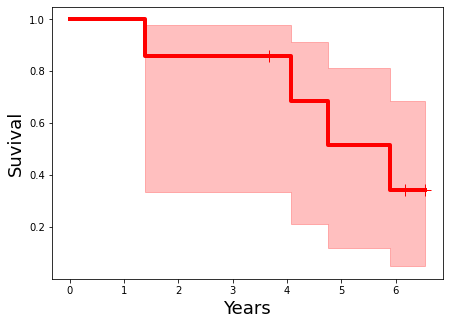

In [11]:
# let's see how it looks
plt.figure(figsize=(7,5))
kmf.plot(
        show_censors=True,
        ci_show=True,
        legend=False,
        lw=4,
        c='red')
plt.xlabel('Years', fontsize=18)
plt.ylabel('Suvival', fontsize=18);

In [25]:
kmf._median

5.89

In [26]:
kmf.survival_function_

,KM_estimate
timeline,
0.00,1.000000
1.39,0.857143
3.67,0.857143
4.07,0.685714
4.76,0.514286
5.89,0.342857
6.17,0.342857
6.54,0.342857


In [14]:
# how do we compute the fraction survival?
print(6/7)
print(6/7 * 4/5)
print(6/7 * 4/5 * 3/4)

0.8571428571428571
0.6857142857142857
0.5142857142857142


Basically, the estimator of the survival function $S(t)$, also known as the probability that life is longer than $t$, is given by:
$$\hat{S}(t) = \prod_{i: t_i \le{t}}(1 - \frac{d_i}{n_i})$$

In [1]:
# for instance at t=4.07 years
(1 - 1/7) * (1 - 0/6) * (1 - 1/5) # because 1 individual censored at year 1.39

0.6857142857142858

In [2]:
# for t=3.67
(1 - 1/7) * (1 - 0/6)

0.8571428571428572

## Playing a bit further with the lifelines library

In [71]:
# need to create new columns in order to prepare a lifelines Table
data['observed_deaths']= data['CODE'] == 1
data['censored']       = data['CODE'] == 0

In [72]:
# Transforming survival-table data into lifelines format
from lifelines.utils import survival_events_from_table

data.set_index('YEARS', inplace=True)
T, E, W = survival_events_from_table(data, observed_deaths_col='observed_deaths', censored_col='censored')

In [55]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(T, E)
display(table)

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.00,0,0,0,7,7
1.39,1,1,0,0,7
3.67,1,0,1,0,6
4.07,1,1,0,0,5
4.76,1,1,0,0,4
5.89,1,1,0,0,3
6.17,1,0,1,0,2
6.54,1,0,1,0,1


In [13]:
kmf.confidence_interval_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.00,1.000000,1.000000
1.39,0.334054,0.978561
3.67,0.334054,0.978561
4.07,0.212797,0.912112
4.76,0.117760,0.813249
5.89,0.048108,0.685484
6.17,0.048108,0.685484
6.54,0.048108,0.685484


In [67]:
# attempt to compute the CI...
from statsmodels.stats import proportion
conf_int = proportion.proportion_confint(6, 7, method='binom_test')
conf_int

(0.44576337872989324, 0.9926991680210083)

It looks like the method used to compute the CI for survival function is different from the Ward method applied to proportions. See [Lifelines documentations](https://lifelines.readthedocs.io/en/latest/index.html) for more details (it is more complex than at the first sight ;-)